In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn import preprocessing as skp 
from sklearn import decomposition as skd
from sklearn.pipeline import Pipeline
from sklearn import metrics as skm
from sklearn.cluster import KMeans, DBSCAN, MiniBatchKMeans 
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

## Import the data & look at it
In this section, I import the upload traffic and create a new df using a single instance with a single device. I add columns to include the moving average for the upload traffic. I also extract `enter` and `exit` from the dataset to mark the timestamps where I entered the camera's frame and when I exited the frame.

In some cases, I also import traffic from other smart devices that are uploading at the same time as the cameras, specifically a smart TV and a phone.

In [2]:
traffic_data_main = pd.read_csv('../camera_upload_traffic_updated.csv', index_col=0)
traffic_data_main

,frame.time_epoch,action_code,frame.len_per_sec,camera,instance_ID
0,1721404385,1,112.0,Amcrest,Me4tRSv9bVaJXXwoDouJQQ
1,1721404386,0,112.0,Amcrest,Me4tRSv9bVaJXXwoDouJQQ
2,1721404387,0,550.0,Amcrest,Me4tRSv9bVaJXXwoDouJQQ
3,1721404388,0,112.0,Amcrest,Me4tRSv9bVaJXXwoDouJQQ
4,1721404389,0,56.0,Amcrest,Me4tRSv9bVaJXXwoDouJQQ
...,...,...,...,...,...
5542,1733717412,0,0.0,blink 10s,o8i2KKqL8MSyW4edkEjXQE
5543,1733717413,0,0.0,blink 10s,o8i2KKqL8MSyW4edkEjXQE
5544,1733717414,0,0.0,blink 10s,o8i2KKqL8MSyW4edkEjXQE
5545,1733717415,0,246.0,blink 10s,o8i2KKqL8MSyW4edkEjXQE


In [3]:
unique_instances= traffic_data_main['instance_ID'].unique()
unique_instances

array(['Me4tRSv9bVaJXXwoDouJQQ', 'bKYKMgGfRweFWstYP2YNVw',
       'Fx2ftdGeqkJyB4WA25cxAC', 'emqmXzrpv8vnYsZXYADweX',
       'QB6AjsnSeTF6LtjKKHKgKD', 'JLJ95GACVNpsv6S2GWkAAH',
       '2Z3jXcgR9ounHQE6Fwtaqu', 'ncbQ4MtJnmiKgtsS6oa6VV',
       '4i7v83jtVFiXtVHcX3QwPH', 'o3v6mDDHJSYQhQNagKAgWk',
       'PA7arjypKhxvMyJgx9UdLz', 'Qc4sAWjQC4P6jAhzvCBZ2W',
       'CTFCmofM3YpYaM62XW4pfZ', 'LQ9Adja4qSooM9Ltmof9WA',
       'Fd9oXjA9gzMb92TGW6X4Vg', 'k9TW9vZG4dh7oZsEQC85HF',
       'E7S4onXZdiRKSuKimdeRkj', 'GNY4zASCpBY7oNSMBd2pBe',
       'E4oxAfCEK6Eptr4qEvdTWB', 'Sc5To7Pa9qDZfFfqpLgMmT',
       'KbNdDryGratSJQoKMSs9PS', '4HafPJ4jq92Sp6Vaemc6Wa',
       'o87VEqAVAowTwfQDwVDNQj', 'F9tHHvZ87TMQRt3sXwqm5r',
       'CshFoDr7MgMAKAjGaGrYdk', 'XJBpN4BJHp8rAwYtjqaUaQ',
       'oBEUc8UcptZJQCL2RM7bqk', 'gDZvCSdNVgseUzmJx5CFb4',
       'TNGh2jMzJ4J98xrSQMEyub', '68mDghff6C8KzvRJNoMYZm',
       'WLWJyQwjKzHcxutsQG5iQ8', 'RbvfiMKb59HQtfVicrkjfi',
       'axButPfjRzFUfEYPGe2Tgg', 'dRwAAh4oHTTWxcfbGUzwG6

`azzZCv9eL9TAW7P8uv8Y8B` for an example that works perfectly (blink camera)
`dRwAAh4oHTTWxcfbGUzwG6` for one where the camera did not act accordingly (peak was only 300 bytes)
`WLWJyQwjKzHcxutsQG5iQ8` where amcrest peak is normal (increase to 3Mb)


In [4]:
unique_instance = 'azzZCv9eL9TAW7P8uv8Y8B'

In [5]:
single_device_traffic = traffic_data_main.loc[(traffic_data_main['instance_ID']==unique_instance)]
single_device_traffic['byte_count_rolling_5'] = single_device_traffic['frame.len_per_sec'].rolling(5).mean()
single_device_traffic['byte_count_rolling_3'] = single_device_traffic['frame.len_per_sec'].rolling(3).mean()
single_device_traffic = single_device_traffic.fillna(0)
single_device_traffic = single_device_traffic.reset_index()
single_device_traffic['frame.time_epoch'] = single_device_traffic['frame.time_epoch'] - single_device_traffic['frame.time_epoch'][0]

single_device_traffic.head()

/var/folders/ym/9nzlftjn1nx4y249dh31z15r0000gn/T/ipykernel_39279/2348695855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_device_traffic['byte_count_rolling_5'] = single_device_traffic['frame.len_per_sec'].rolling(5).mean()
/var/folders/ym/9nzlftjn1nx4y249dh31z15r0000gn/T/ipykernel_39279/2348695855.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_device_traffic['byte_count_rolling_3'] = single_device_traffic['frame.len_per_sec'].rolling(3).mean()


,index,frame.time_epoch,action_code,frame.len_per_sec,camera,instance_ID,byte_count_rolling_5,byte_count_rolling_3
0,4548,0,1,0.0,blink 10s,azzZCv9eL9TAW7P8uv8Y8B,0.0,0.0
1,4549,1,0,0.0,blink 10s,azzZCv9eL9TAW7P8uv8Y8B,0.0,0.0
2,4550,2,0,0.0,blink 10s,azzZCv9eL9TAW7P8uv8Y8B,0.0,0.0
3,4551,3,0,0.0,blink 10s,azzZCv9eL9TAW7P8uv8Y8B,0.0,0.0
4,4552,4,0,0.0,blink 10s,azzZCv9eL9TAW7P8uv8Y8B,0.0,0.0


In [6]:
traffic_data_noise_phone = pd.read_csv('../phone_noise_upload_traffic.csv', index_col=0)
phone_traffic = traffic_data_noise_phone.loc[(traffic_data_noise_phone['instance_ID']==unique_instance)]
phone_traffic['byte_count_rolling_5'] = phone_traffic['frame.len_per_sec'].rolling(5).mean()
phone_traffic['byte_count_rolling_3'] = phone_traffic['frame.len_per_sec'].rolling(3).mean()
phone_traffic = phone_traffic.fillna(0)
phone_traffic= phone_traffic.reset_index()
phone_traffic['frame.time_epoch'] = phone_traffic['frame.time_epoch'] - phone_traffic['frame.time_epoch'][0]

traffic_data_noise_tv = pd.read_csv('../smart_tv_upload_traffic.csv', index_col=0)
tv_traffic = traffic_data_noise_tv.loc[(traffic_data_noise_tv['instance_ID']==unique_instance)]
tv_traffic['byte_count_rolling_5'] = tv_traffic['frame.len_per_sec'].rolling(5).mean()
tv_traffic['byte_count_rolling_3'] = tv_traffic['frame.len_per_sec'].rolling(3).mean()
tv_traffic = tv_traffic.fillna(0)
tv_traffic= tv_traffic.reset_index()
tv_traffic['frame.time_epoch'] = tv_traffic['frame.time_epoch'] - tv_traffic['frame.time_epoch'][0]

/var/folders/ym/9nzlftjn1nx4y249dh31z15r0000gn/T/ipykernel_39279/326869920.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phone_traffic['byte_count_rolling_5'] = phone_traffic['frame.len_per_sec'].rolling(5).mean()
/var/folders/ym/9nzlftjn1nx4y249dh31z15r0000gn/T/ipykernel_39279/326869920.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phone_traffic['byte_count_rolling_3'] = phone_traffic['frame.len_per_sec'].rolling(3).mean()
/var/folders/ym/9nzlftjn1nx4y249dh31z15r0000gn/T/ipykernel_39279/3268699

In [7]:
enter = int(single_device_traffic['frame.time_epoch'].loc[(single_device_traffic['action_code']==2)]) 
exit = int(single_device_traffic['frame.time_epoch'].loc[(single_device_traffic['action_code']==3)]) 
print("Enter: ", enter,"\nExit: ", exit)


Enter:  36 
Exit:  52


/var/folders/ym/9nzlftjn1nx4y249dh31z15r0000gn/T/ipykernel_39279/3693990381.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  enter = int(single_device_traffic['frame.time_epoch'].loc[(single_device_traffic['action_code']==2)])
/var/folders/ym/9nzlftjn1nx4y249dh31z15r0000gn/T/ipykernel_39279/3693990381.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  exit = int(single_device_traffic['frame.time_epoch'].loc[(single_device_traffic['action_code']==3)])


Text(0, 0.5, 'bytes/s')

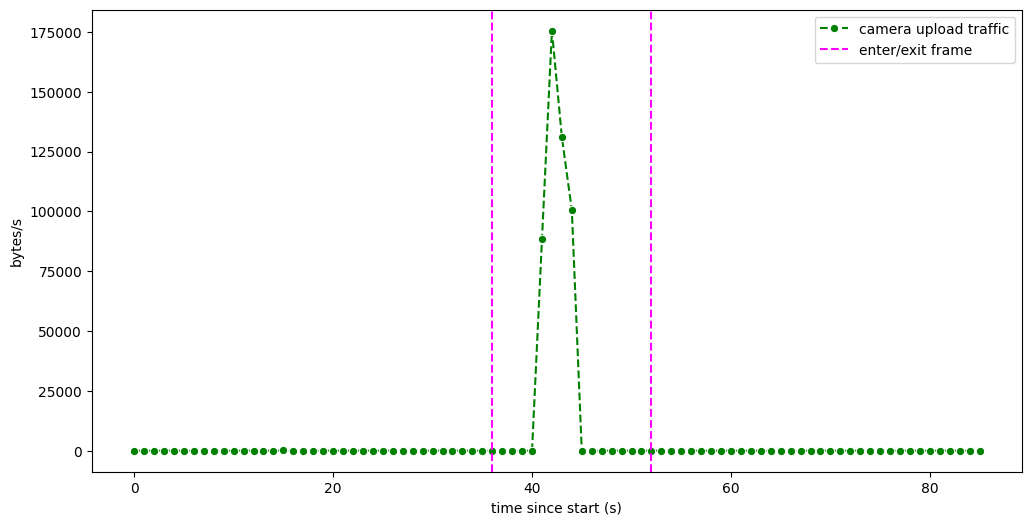

In [8]:
fig = plt.figure(figsize=(12,6))

sns.lineplot(data=single_device_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'camera upload traffic', color='green')
# sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='-',linestyle='dashed', label='rolling avg - 5 sec', color='green')
# sns.lineplot(data=single_device_traffic['byte_count_rolling_3'],marker='o',linestyle='dashed', label='rolling avg - 3 sec')
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta', label ='enter/exit frame')
plt.legend()
plt.xlabel('time since start (s)')
plt.ylabel('bytes/s')

Text(0, 0.5, 'bytes/s')

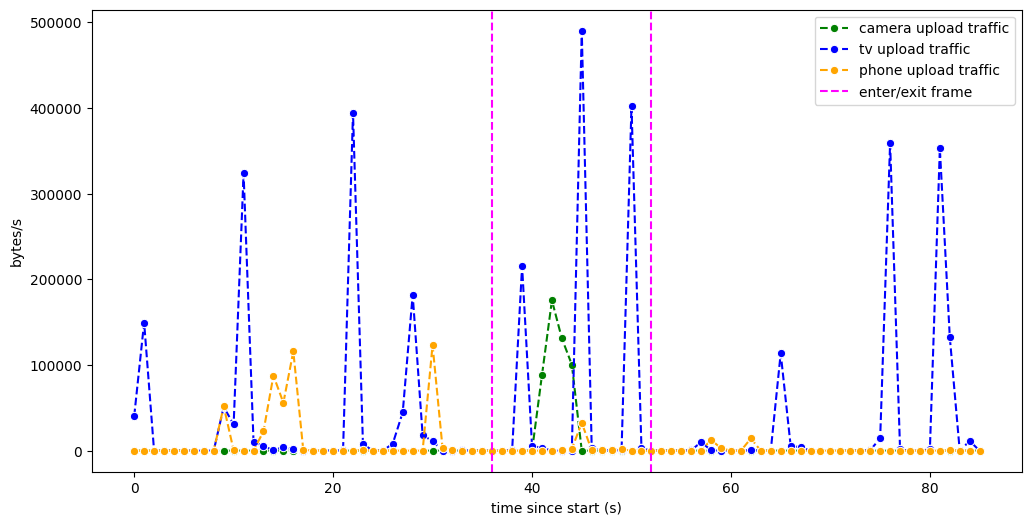

In [9]:
fig = plt.figure(figsize=(12,6))

sns.lineplot(data=single_device_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'camera upload traffic', color='green')
sns.lineplot(data=tv_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'tv upload traffic', color='blue')
sns.lineplot(data=phone_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'phone upload traffic', color='orange')
# sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='-',linestyle='dashed', label='rolling avg - 5 sec', color='green')
# sns.lineplot(data=single_device_traffic['byte_count_rolling_3'],marker='o',linestyle='dashed', label='rolling avg - 3 sec')
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta', label ='enter/exit frame')
plt.legend()
plt.xlabel('time since start (s)')
plt.ylabel('bytes/s')

## Statistically search for spikes
In this section, I use mean and standard deviation, or z-score, to detect spikes in the time-series data. If a spike only occurs while I'm in the frame of the camera, then the device is likely a camera.

In [10]:
upload_std = single_device_traffic['frame.len_per_sec'].std()
upload_mean = single_device_traffic['frame.len_per_sec'].mean()

sma_5_std =  single_device_traffic['byte_count_rolling_5'].std()
sma_5_mean =  single_device_traffic['byte_count_rolling_5'].mean()

phone_std = phone_traffic['frame.len_per_sec'].std()
phone_mean = phone_traffic['frame.len_per_sec'].mean()

phone_sma_5_std =  phone_traffic['byte_count_rolling_5'].std()
phone_sma_5_mean =  phone_traffic['byte_count_rolling_5'].mean()

tv_std = tv_traffic['frame.len_per_sec'].std()
tv_mean = tv_traffic['frame.len_per_sec'].mean()

tv_sma_5_std =  tv_traffic['byte_count_rolling_5'].std()
tv_sma_5_mean =  tv_traffic['byte_count_rolling_5'].mean()

In [11]:
spike = single_device_traffic.loc[single_device_traffic['frame.len_per_sec'] > upload_mean+3*upload_std]
camera_spike_df =single_device_traffic[['frame.time_epoch','frame.len_per_sec']].loc[spike.index]
camera_spike_df.head()

,frame.time_epoch,frame.len_per_sec
41,41,88407.0
42,42,175521.0
43,43,131037.0
44,44,100588.0


In [12]:
spike_sma_5 = single_device_traffic.loc[single_device_traffic['byte_count_rolling_5'] > sma_5_mean+3*sma_5_std]
                                        
camera_spike_sma_5_df= single_device_traffic[['frame.time_epoch','byte_count_rolling_5']].loc[spike_sma_5.index]
camera_spike_sma_5_df.head()


,frame.time_epoch,byte_count_rolling_5
43,43,78993.0
44,44,99110.6
45,45,99110.6
46,46,81429.2


In [13]:
phone_spike = phone_traffic.loc[phone_traffic['frame.len_per_sec'] > phone_mean+3*phone_std]
phone_spike_df =phone_traffic[['frame.time_epoch','frame.len_per_sec']].loc[phone_spike.index]
phone_spike_df.head()

,frame.time_epoch,frame.len_per_sec
14,14,87784.0
16,16,115948.0
30,30,123393.0


In [14]:
phone_spike_sma_5 = phone_traffic.loc[phone_traffic['byte_count_rolling_5'] > phone_sma_5_mean+3*phone_sma_5_std]

phone_spike_sma_5_df= phone_traffic[['frame.time_epoch','byte_count_rolling_5']].loc[phone_spike_sma_5.index]
phone_spike_sma_5_df.head()

,frame.time_epoch,byte_count_rolling_5
16,16,56491.6
17,17,56643.8
18,18,52157.4


In [15]:
tv_spike = tv_traffic.loc[tv_traffic['frame.len_per_sec'] > tv_mean+3*tv_std]
tv_spike_df =tv_traffic[['frame.time_epoch','frame.len_per_sec']].loc[tv_spike.index]
tv_spike_df.head()

,frame.time_epoch,frame.len_per_sec
22,22,394616.0
45,45,490345.0
50,50,402408.0
76,76,359291.0
81,81,352976.0


In [16]:
tv_spike_sma_5 = tv_traffic.loc[tv_traffic['byte_count_rolling_5'] > tv_sma_5_mean+3*tv_sma_5_std]

tv_spike_sma_5_df= tv_traffic[['frame.time_epoch','byte_count_rolling_5']].loc[tv_spike_sma_5.index]
tv_spike_sma_5_df.head()

,frame.time_epoch,byte_count_rolling_5


Text(0, 0.5, 'bytes')

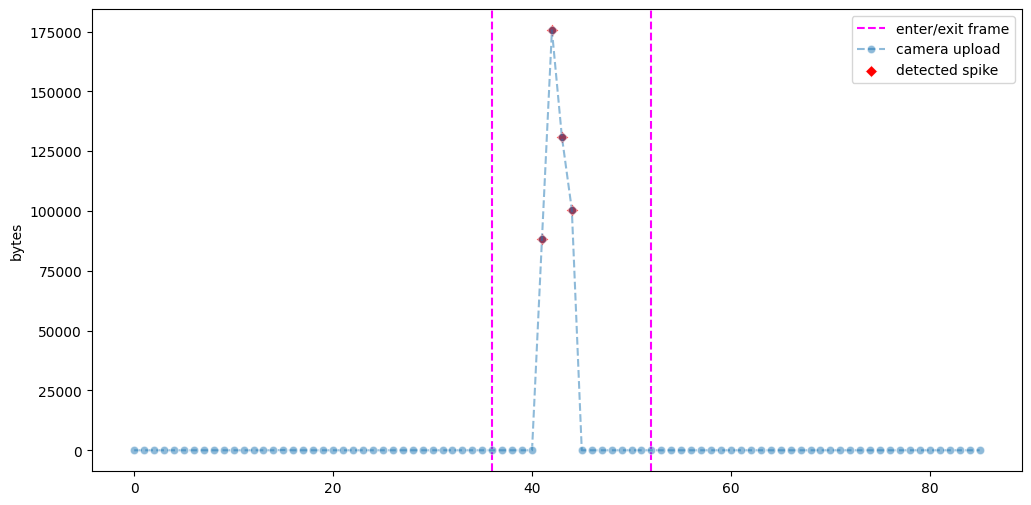

In [17]:
fig = plt.figure(figsize=(12,6))
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta', label='enter/exit frame')
sns.lineplot(data=single_device_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'camera upload', alpha=0.5)
# sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label='rolling avg - 5 sec', alpha=0.5)
sns.scatterplot(data=camera_spike_df['frame.len_per_sec'],marker='D',color = 'red', label='detected spike')
# plt.axvline(x=enter, ls = '--', color='magenta')
# plt.axvline(x=exit, ls = '--', color='magenta')
# plt.xlabel('time since start (s)')
plt.legend()
plt.ylabel('bytes')

Text(0, 0.5, 'bytes')

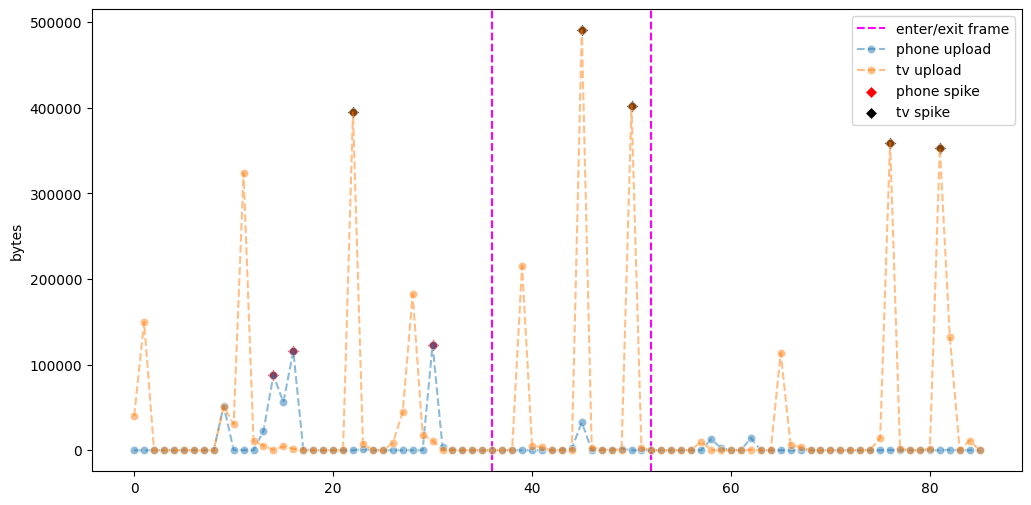

In [18]:
fig = plt.figure(figsize=(12,6))
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta', label='enter/exit frame')
sns.lineplot(data=phone_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'phone upload', alpha=0.5)
sns.lineplot(data=tv_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'tv upload', alpha=0.5)
# sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label='rolling avg - 5 sec', alpha=0.5)
sns.scatterplot(data=phone_spike_df['frame.len_per_sec'],marker='D',color = 'red', label='phone spike')
sns.scatterplot(data=tv_spike_df['frame.len_per_sec'],marker='D',color = 'black', label='tv spike')
# plt.axvline(x=enter, ls = '--', color='magenta')
# plt.axvline(x=exit, ls = '--', color='magenta')
# plt.xlabel('time since start (s)')
plt.legend()
plt.ylabel('bytes')

### Now look at the SMA results

Text(0, 0.5, 'bytes')

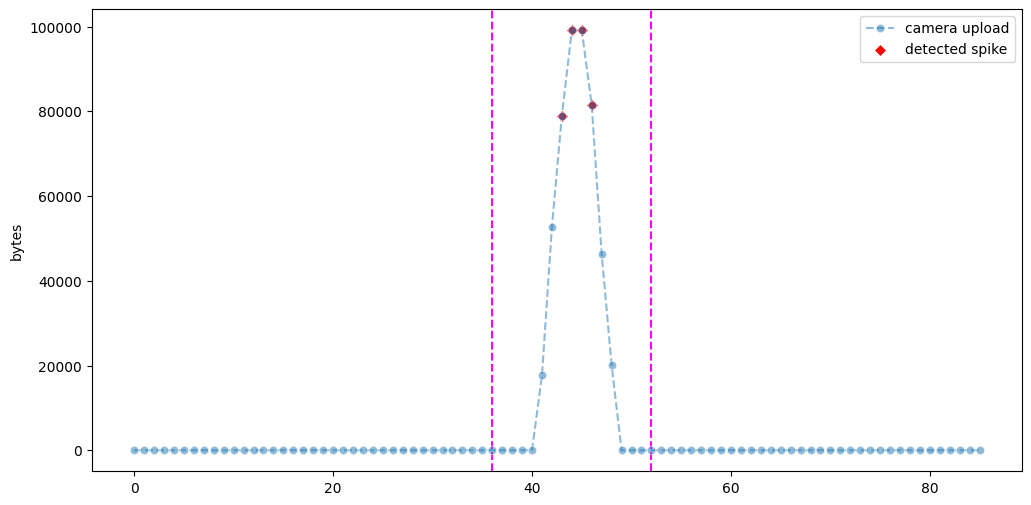

In [19]:
fig = plt.figure(figsize=(12,6))
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta')
sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label= 'camera upload', alpha=0.5)
# sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label='rolling avg - 5 sec', alpha=0.5)
sns.scatterplot(data=camera_spike_sma_5_df['byte_count_rolling_5'],marker='D',color = 'red', label='detected spike')
# plt.axvline(x=enter, ls = '--', color='magenta')
# plt.axvline(x=exit, ls = '--', color='magenta')
# plt.xlabel('time since start (s)')
plt.ylabel('bytes')

Text(0, 0.5, 'bytes')

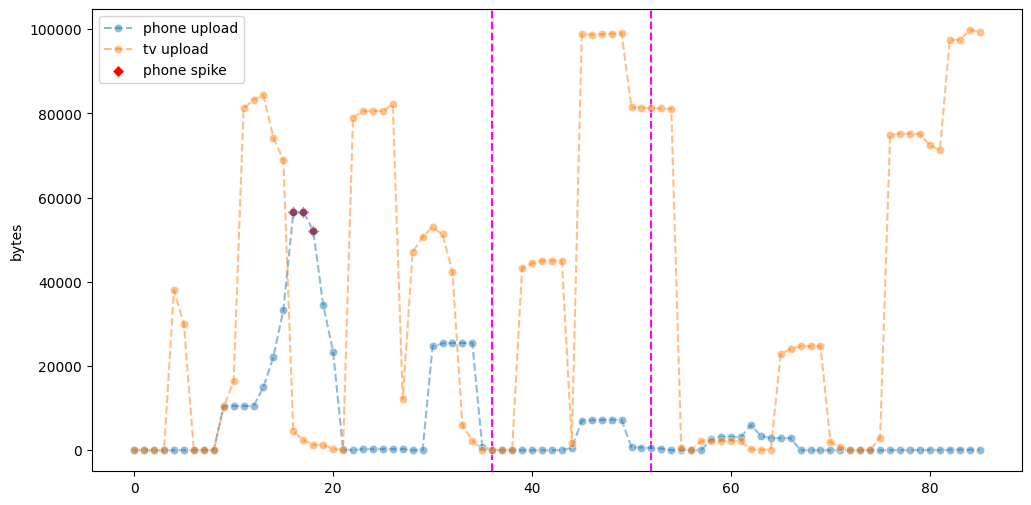

In [20]:
fig = plt.figure(figsize=(12,6))
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta')
sns.lineplot(data=phone_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label= 'phone upload', alpha=0.5)
sns.lineplot(data=tv_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label= 'tv upload', alpha=0.5)
# sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label='rolling avg - 5 sec', alpha=0.5)
sns.scatterplot(data=phone_spike_sma_5_df['byte_count_rolling_5'],marker='D',color = 'red', label='phone spike')
sns.scatterplot(data=tv_spike_sma_5_df['byte_count_rolling_5'],marker='D',color = 'black', label='tv spike')
# plt.axvline(x=enter, ls = '--', color='magenta')
# plt.axvline(x=exit, ls = '--', color='magenta')
# plt.xlabel('time since start (s)')
plt.ylabel('bytes')

## ML Methods for Spike Detection
A natural ML parallel for this type of technique is unsupervised clustering. In this section I will perform the same analysis using DBSCAN

In [21]:
# Create our X and Y. 
X_Columns = ['frame.len_per_sec']
Raw_X = single_device_traffic['frame.len_per_sec'].to_numpy().reshape(-1,1)


def scale_data(X):
    return skp.MinMaxScaler().fit_transform(X)

X = scale_data(Raw_X)

In [22]:
class ClusterClass:
    def __init__(self):
        self.alg = self.getAlgorithm()

    def fit(self, X):
        self.alg.fit(X)

    def predict(self, X):
        if hasattr(self.alg, "labels_"):
            y_pred = self.alg.labels_.astype(int)
        else:
            y_pred = self.alg.predict(X)
        return y_pred

    def fit_predict(self,X):
        self.fit(X)
        return self.predict(X)
        

class DBSCANClass(ClusterClass):
    def getAlgorithm(self):
        return DBSCAN(eps=0.1)
    
def predict(X,Y,classifier,F1):
    scaler = skp.MinMaxScaler()
    scaled_X = scaler.fit_transform(X)
    pred = classifier.fit_predict(X)
    return pred

In [23]:
Y = 0
clusters = predict(X,Y,DBSCANClass(),'frame.len_per_sec')
peaks = np.where(clusters == -1)
peaks

(array([41, 42, 43, 44]),)

In [24]:
clusters

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0])

In [25]:
ml_camera_spike_df =single_device_traffic[['frame.time_epoch','frame.len_per_sec']].loc[peaks]
ml_camera_spike_df.head()

,frame.time_epoch,frame.len_per_sec
41,41,88407.0
42,42,175521.0
43,43,131037.0
44,44,100588.0


Text(0, 0.5, 'bytes')

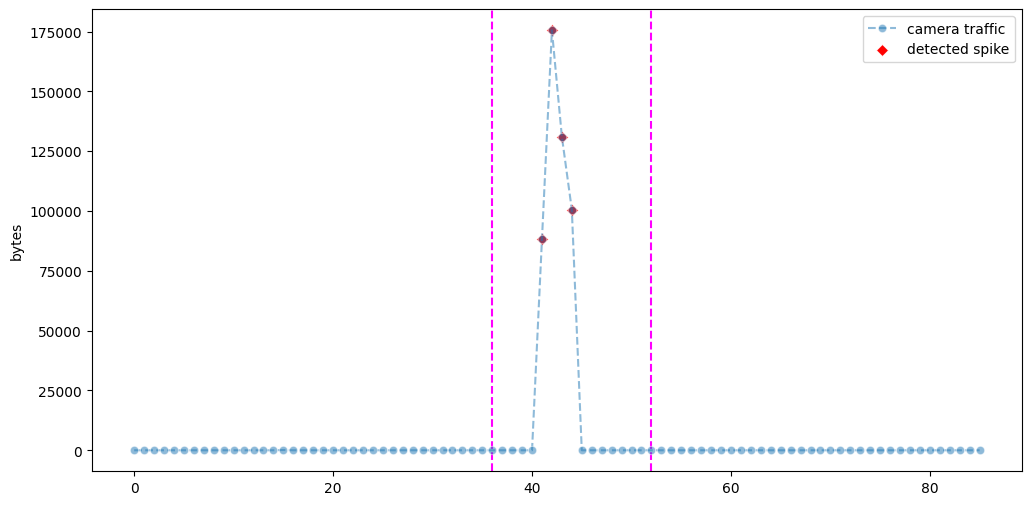

In [26]:
fig = plt.figure(figsize=(12,6))
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta')
sns.lineplot(data=single_device_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'camera traffic', alpha=0.5)
sns.scatterplot(data=ml_camera_spike_df['frame.len_per_sec'],marker='D',color = 'red', label='detected spike')
# plt.axvline(x=enter, ls = '--', color='magenta')
# plt.axvline(x=exit, ls = '--', color='magenta')
# plt.xlabel('time since start (s)')
plt.legend()
plt.ylabel('bytes')

repeat for the noisy traffic

In [27]:

X_Columns = ['frame.len_per_sec']
Raw_X_tv = tv_traffic['frame.len_per_sec'].to_numpy().reshape(-1,1)

X_tv = scale_data(Raw_X_tv)

clusters_tv = predict(X_tv,Y,DBSCANClass(),'frame.len_per_sec')
peaks_tv = np.where(clusters_tv == -1)
peaks_tv



(array([ 1, 28, 39, 45, 65, 82]),)

In [28]:
ml_tv_spike_df =tv_traffic[['frame.time_epoch','frame.len_per_sec']].loc[peaks_tv]
ml_tv_spike_df.head()

,frame.time_epoch,frame.len_per_sec
1,1,149688.0
28,28,182134.0
39,39,215534.0
45,45,490345.0
65,65,113762.0


In [29]:

X_Columns = ['frame.len_per_sec']
Raw_X_phone = phone_traffic['frame.len_per_sec'].to_numpy().reshape(-1,1)

X_phone = scale_data(Raw_X_phone)

clusters_phone = predict(X_phone,Y,DBSCANClass(),'frame.len_per_sec')
peaks_phone = np.where(clusters_phone == -1)
peaks_phone


(array([ 9, 14, 15, 16, 30, 45]),)

In [30]:
ml_phone_spike_df =phone_traffic[['frame.time_epoch','frame.len_per_sec']].loc[peaks_phone]
ml_phone_spike_df.head()

,frame.time_epoch,frame.len_per_sec
9,9,51976.0
14,14,87784.0
15,15,56011.0
16,16,115948.0
30,30,123393.0


Text(0, 0.5, 'bytes')

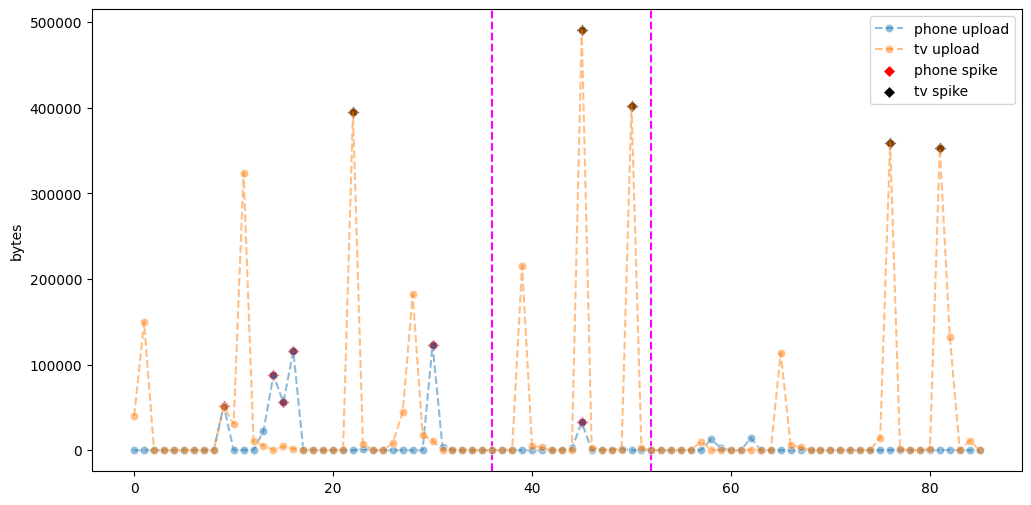

In [31]:
fig = plt.figure(figsize=(12,6))
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta')
sns.lineplot(data=phone_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'phone upload', alpha=0.5)
sns.lineplot(data=tv_traffic['frame.len_per_sec'],marker='o',linestyle='dashed', label= 'tv upload', alpha=0.5)
# sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label='rolling avg - 5 sec', alpha=0.5)
sns.scatterplot(data=ml_phone_spike_df['frame.len_per_sec'],marker='D',color = 'red', label='phone spike')
sns.scatterplot(data=tv_spike_df['frame.len_per_sec'],marker='D',color = 'black', label='tv spike')
# plt.axvline(x=enter, ls = '--', color='magenta')
# plt.axvline(x=exit, ls = '--', color='magenta')
# plt.xlabel('time since start (s)')
plt.ylabel('bytes')

### Repeat with Smoothed curves

In [32]:

Raw_X_sma5 = single_device_traffic['byte_count_rolling_5'].to_numpy().reshape(-1,1)

X_sma5 = scale_data(Raw_X_sma5)

clusters_sma5 = predict(X_sma5,Y,DBSCANClass(),'byte_count_rolling_5')
peaks_sma5 = np.where(clusters_sma5 == -1)
ml_camera_spike_sma5_df =single_device_traffic[['frame.time_epoch','byte_count_rolling_5']].loc[peaks_sma5]
ml_camera_spike_sma5_df.head()


,frame.time_epoch,byte_count_rolling_5
41,41,17681.4
42,42,52785.6
43,43,78993.0
44,44,99110.6
45,45,99110.6


In [33]:

Raw_X_tv_sma5 = tv_traffic['byte_count_rolling_5'].to_numpy().reshape(-1,1)

X_tv_sma5 = scale_data(Raw_X_tv_sma5)

clusters_tv_sma5 = predict(X_tv_sma5,Y,DBSCANClass(),'byte_count_rolling_5')
peaks_tv_sma5 = np.where(clusters_tv_sma5 == -1)
ml_tv_spike_sma5_df =tv_traffic[['frame.time_epoch','byte_count_rolling_5']].loc[peaks_tv_sma5]
ml_tv_spike_sma5_df.head()

,frame.time_epoch,byte_count_rolling_5


In [34]:
Raw_X_phone_sma5 = phone_traffic['byte_count_rolling_5'].to_numpy().reshape(-1,1)

X_phone_sma5 = scale_data(Raw_X_phone_sma5)

clusters_phone_sma5 = predict(X_phone_sma5,Y,DBSCANClass(),'byte_count_rolling_5')
peaks_phone_sma5 = np.where(clusters_phone_sma5 == -1)
ml_phone_spike_sma5_df =phone_traffic[['frame.time_epoch','byte_count_rolling_5']].loc[peaks_phone_sma5]
ml_phone_spike_sma5_df.head()

,frame.time_epoch,byte_count_rolling_5
15,15,33321.2
16,16,56491.6
17,17,56643.8
18,18,52157.4
19,19,34600.6


Text(0, 0.5, 'bytes')

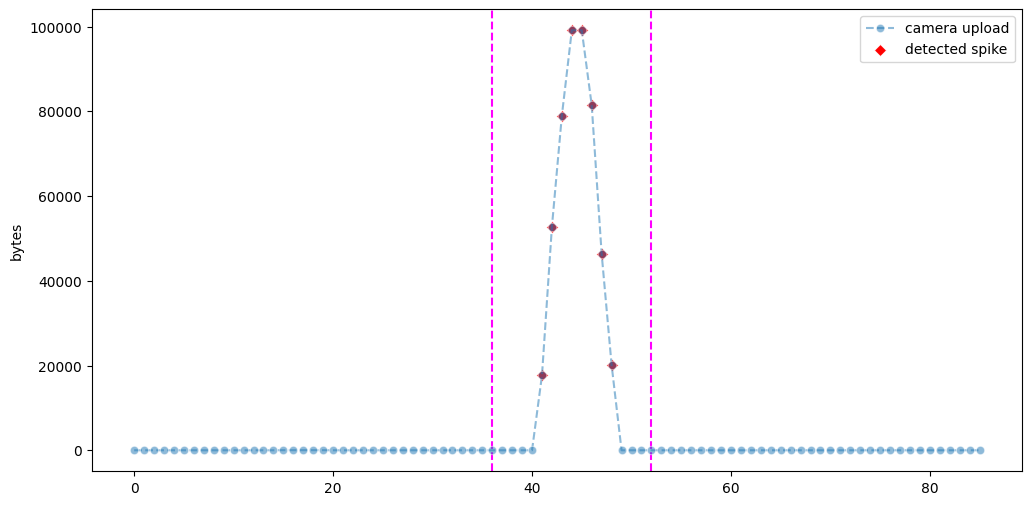

In [35]:
fig = plt.figure(figsize=(12,6))
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta')
sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label= 'camera upload', alpha=0.5)
sns.scatterplot(data=ml_camera_spike_sma5_df['byte_count_rolling_5'],marker='D',color = 'red', label='detected spike')
# plt.axvline(x=enter, ls = '--', color='magenta')
# plt.axvline(x=exit, ls = '--', color='magenta')
# plt.xlabel('time since start (s)')
plt.ylabel('bytes')

Text(0, 0.5, 'bytes')

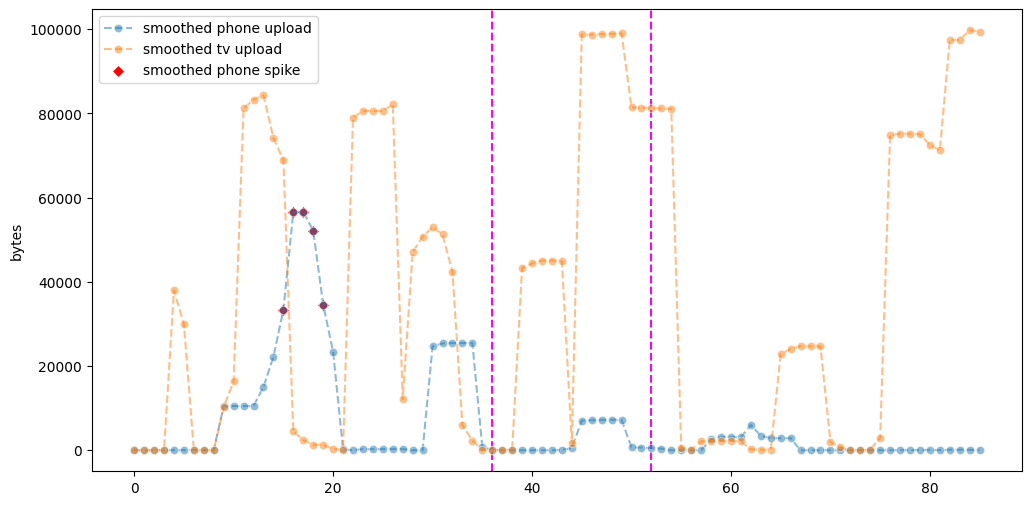

In [36]:
fig = plt.figure(figsize=(12,6))
plt.axvline(x=enter, ls = '--', color='magenta')
plt.axvline(x=exit, ls = '--', color='magenta')
sns.lineplot(data=phone_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label= 'smoothed phone upload', alpha=0.5)
sns.lineplot(data=tv_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label= 'smoothed tv upload', alpha=0.5)
# sns.lineplot(data=single_device_traffic['byte_count_rolling_5'],marker='o',linestyle='dashed', label='rolling avg - 5 sec', alpha=0.5)
sns.scatterplot(data=ml_phone_spike_sma5_df['byte_count_rolling_5'],marker='D',color = 'red', label='smoothed phone spike')
sns.scatterplot(data=ml_tv_spike_sma5_df['byte_count_rolling_5'],marker='D',color = 'black', label='smoothed tv spike')
# plt.axvline(x=enter, ls = '--', color='magenta')
# plt.axvline(x=exit, ls = '--', color='magenta')
# plt.xlabel('time since start (s)')
plt.ylabel('bytes')

## Classify as camera or not

In [58]:
camera_spike_df.index

stat_cam = [not camera_spike_df.index.size == 0 and (camera_spike_df.index > enter).all() and (camera_spike_df.index <= (exit+10)).all()]
stat_cam_sm_5 = [not camera_spike_sma_5_df.index.size == 0 and (camera_spike_sma_5_df.index > enter).all() and (camera_spike_sma_5_df.index <= (exit+10)).all()]

ml_cam =[not ml_camera_spike_df.index.size ==0 and (ml_camera_spike_df.index > enter).all() and (ml_camera_spike_df.index <= (exit+10)).all()]  
ml_cam_sma_5 = [not ml_camera_spike_sma5_df.index.size ==0 and (ml_camera_spike_sma5_df.index > enter).all() and (ml_camera_spike_sma5_df.index <= (exit+10)).all()]  

stat_phone = [not phone_spike_df.index.size == 0 and (phone_spike_df.index > enter).all() and (phone_spike_df.index <= (exit+10)).all()]  
stat_phone_sma5 = [not phone_spike_sma_5_df.index.size ==0 and (phone_spike_sma_5_df.index > enter).all() and (phone_spike_sma_5_df.index <= (exit+10)).all()]  

ml_phone = [not ml_phone_spike_df.index.size == 0 and (ml_phone_spike_df.index > enter).all() and (ml_phone_spike_df.index <= (exit+10)).all()] 
ml_phone_sma5 = [not ml_phone_spike_sma5_df.index.size == 0 and (ml_phone_spike_sma5_df.index > enter).all() and (ml_phone_spike_sma5_df.index <= (exit+10)).all()] 

stat_tv = [not tv_spike_df.index.size == 0 and (tv_spike_df.index > enter).all() and (tv_spike_df.index <= (exit+10)).all()]  
stat_tv_sma5 = [not tv_spike_sma_5_df.index.size == 0 and (tv_spike_sma_5_df.index > enter).all() and (tv_spike_sma_5_df.index <= (exit+10)).all()]  

# ml_tv = [(ml_tv_spike_df.index > enter).all() and (ml_tv_spike_df.index <= (exit+10)).all()] 
ml_tv = [not ml_tv_spike_df.index.size == 0 and (ml_tv_spike_df.index > enter).all() and (ml_tv_spike_df.index <= (exit+10)).all()] 
ml_tv_sma5 = [not ml_tv_spike_sma5_df.index.size == 0 and (ml_tv_spike_sma5_df.index > enter).all() and (ml_tv_spike_sma5_df.index <= (exit+10)).all()] 

print(f"Analyzing original traffic traces using standard score, for each trace, True means it is a camera. False measns it is not a camera: \n Camera: {stat_cam[0]} \n Phone: {stat_phone[0]} \n TV: {stat_tv[0]} ")
print(f"Analyzing the moving average traffic traces using standard score, for each trace, True means it is a camera. False measns it is not a camera: \n Camera: {stat_cam_sm_5[0]} \n Phone: {stat_phone_sma5[0]} \n TV: {stat_tv_sma5[0]} ")

print(f"Analyzing original traffic traces using DBSCAN, for each trace, True means it is a camera. False measns it is not a camera: \n Camera: {ml_cam[0]} \n Phone: {ml_phone[0]} \n TV: {ml_tv[0]} ")
print(f"Analyzing the moving average traffic traces using DBSCAN for each trace, True means it is a camera. False means it is not a camera: \n Camera: {ml_cam_sma_5[0]} \n Phone: {ml_phone_sma5[0]} \n TV: {ml_tv_sma5[0]} ")

Analyzing original traffic traces using standard score, for each trace, True means it is a camera. False measns it is not a camera: 
 Camera: True 
 Phone: False 
 TV: False 
Analyzing the moving average traffic traces using standard score, for each trace, True means it is a camera. False measns it is not a camera: 
 Camera: True 
 Phone: False 
 TV: False 
Analyzing original traffic traces using DBSCAN, for each trace, True means it is a camera. False measns it is not a camera: 
 Camera: True 
 Phone: False 
 TV: False 
Analyzing the moving average traffic traces using DBSCAN for each trace, True means it is a camera. False means it is not a camera: 
 Camera: True 
 Phone: False 
 TV: False 
